# Basic CNN for traffic sign recognition
## Christian Igel, 2022

This notebook provides a template for a small CNN for the German Traffic Sign Recognition Benchmark. The data is described in:

Johannes Stallkamp, Marc Schlipsing, Jan Salmen, and Christian Igel. Man vs. Computer: Benchmarking Machine Learning Algorithms for Traffic Sign Recognition. *Neural Networks* **32**, pp. 323-332, 2012

This notebook is a template, without modification the model does not even come close to the state-of-the-art. 

Please [contact me](mailto:igel@diku.dk) if you have suggestions for improving the notebook.

Do the imports first:

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch 
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torchvision.datasets.utils import download_url, extract_archive

Check if a GPU is available:

In [2]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cpu


The GTSRB data wrapped in a `Dataset`. This is implemented in the file `GTSRBTrafficSigns.py`. Let's import the class:

In [3]:
from GTSRBTrafficSigns import GTSRBTrafficSigns

In [4]:
dataset_train = GTSRBTrafficSigns()

100.0%


Define the data loader for training:

In [5]:
batch_size = 128
generator_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)

In [6]:
print("Number of training patterns:", dataset_train.__len__())

Number of training patterns: 39209


Let's visualize some input images. This visualization is very important, among others to verify that the data augmentation works as expected.

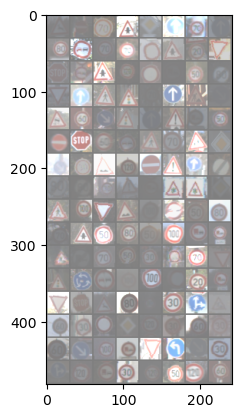

In [7]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(generator_train)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

Let's look at each image in the batch with its label:

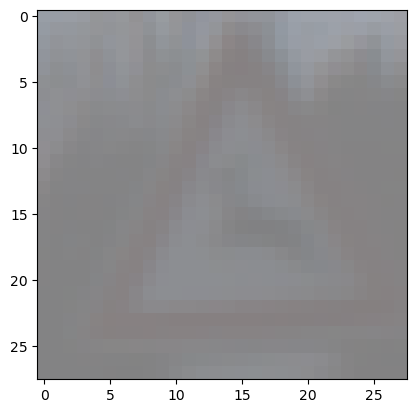

31 




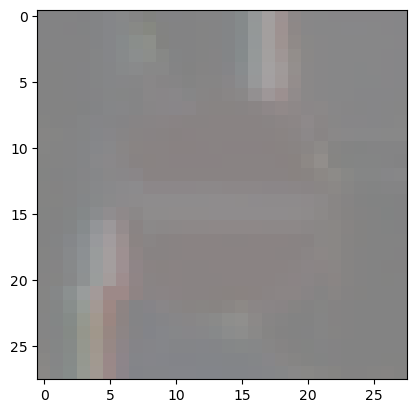

17 




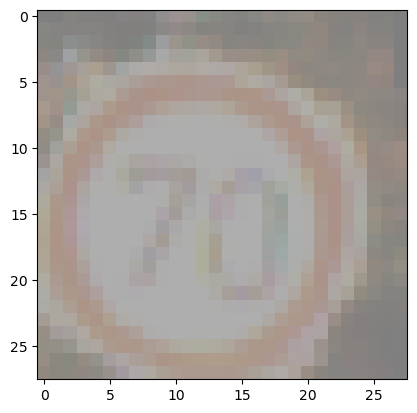

4 




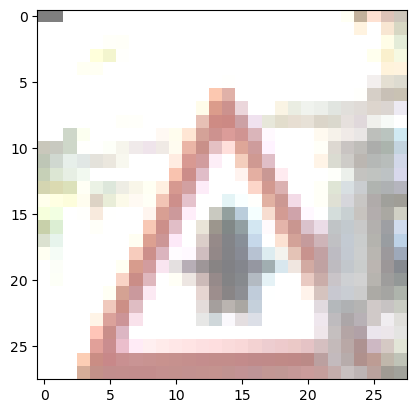

11 




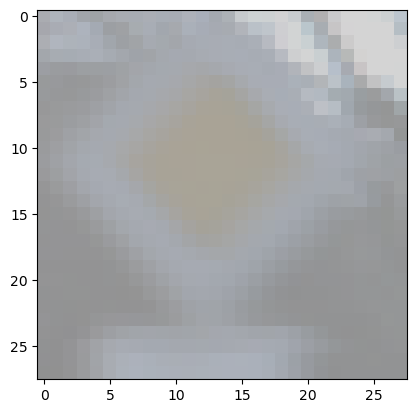

12 




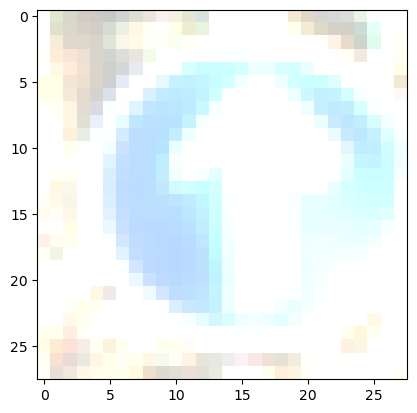

35 




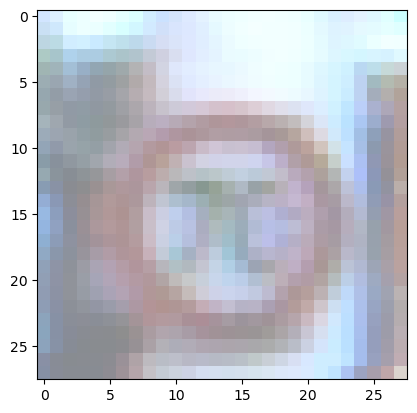

4 




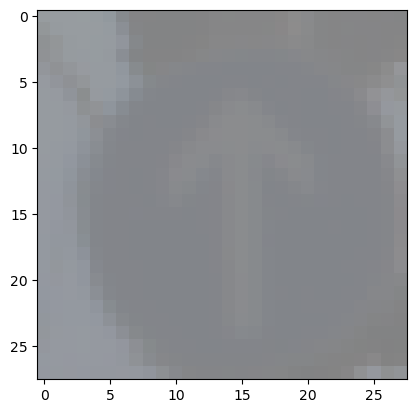

35 




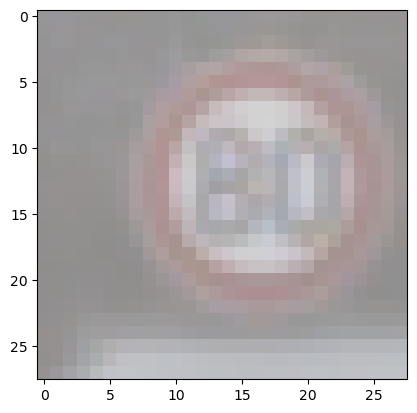

5 




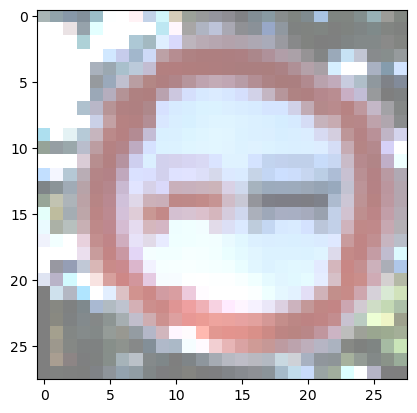

9 




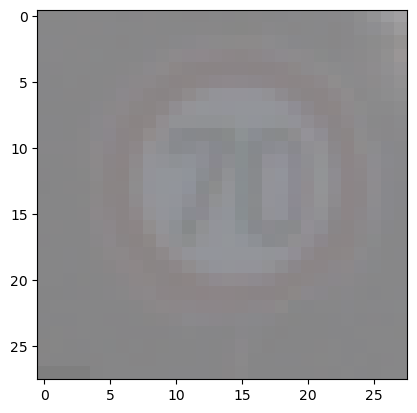

4 




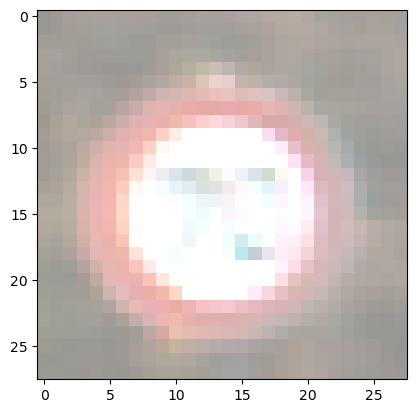

4 




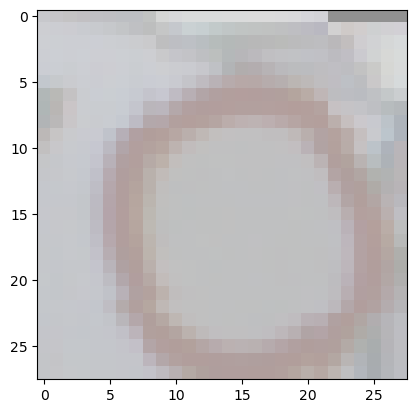

15 




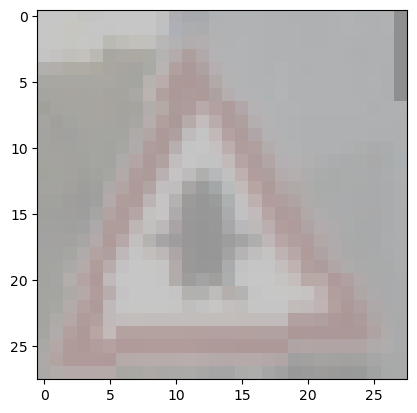

11 




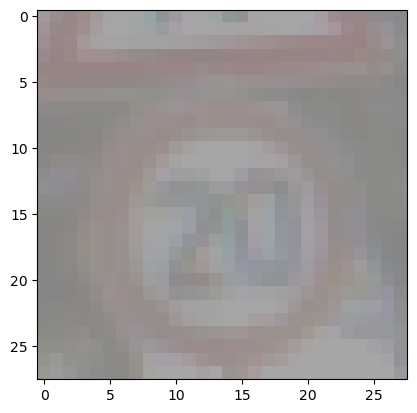

0 




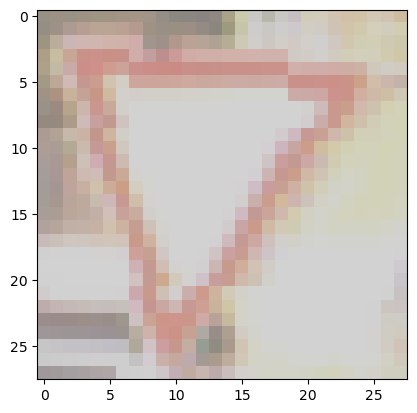

13 




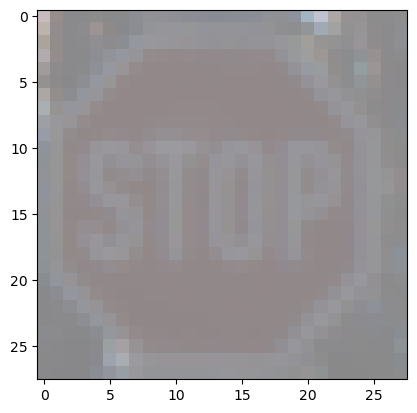

14 




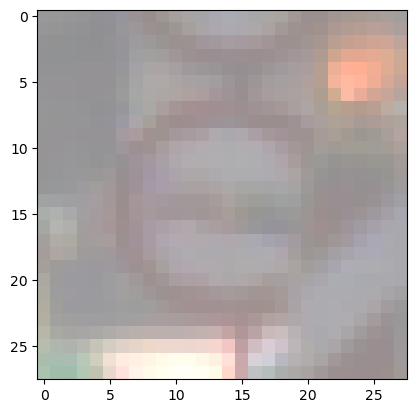

9 




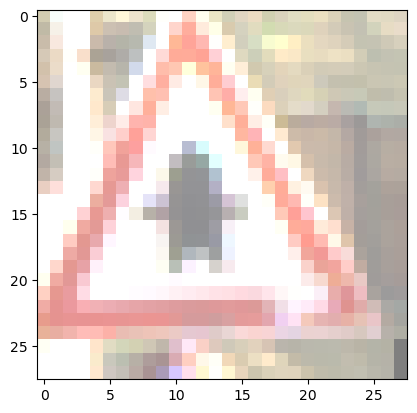

11 




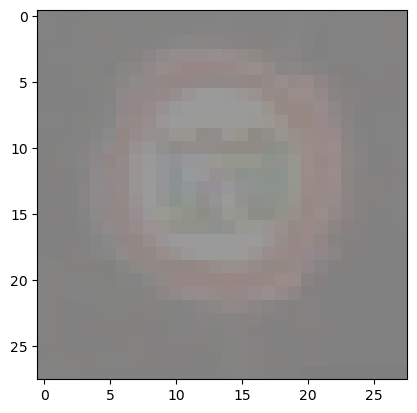

8 




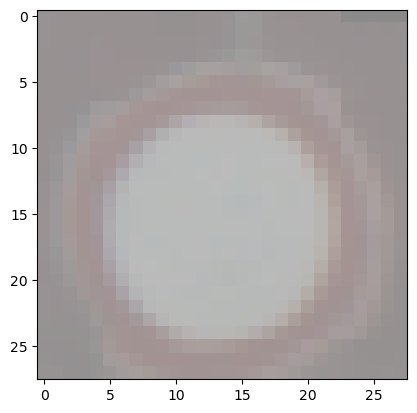

15 




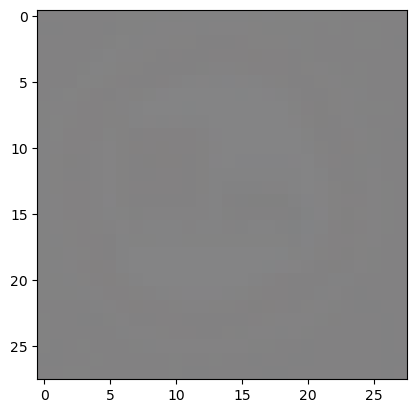

10 




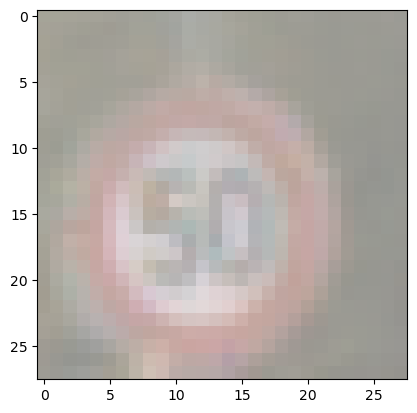

2 




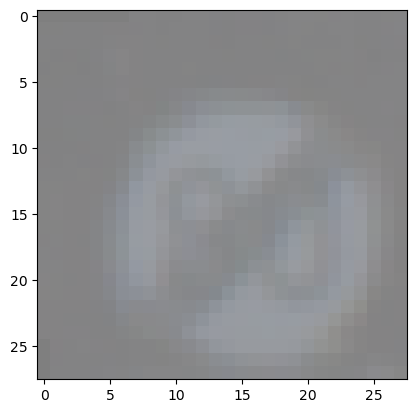

6 




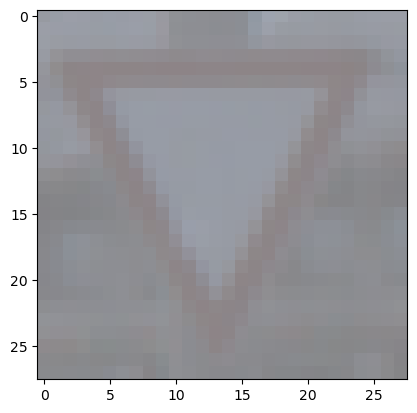

13 




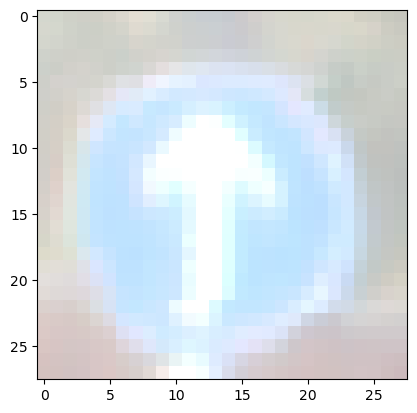

35 




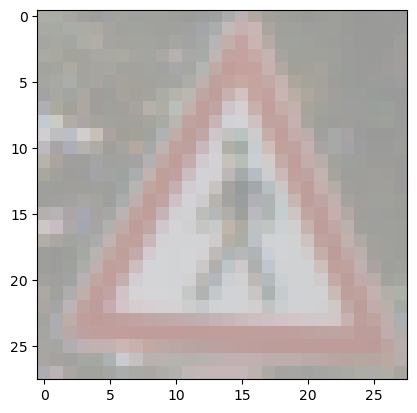

27 




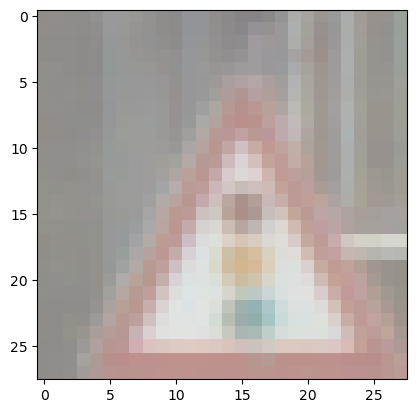

26 




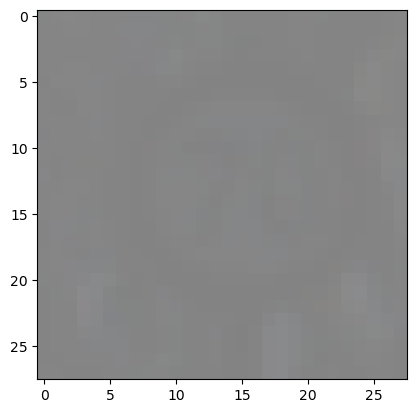

4 




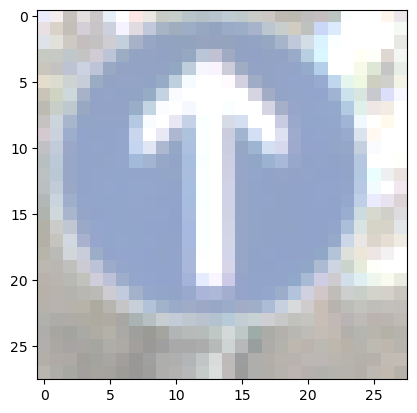

35 




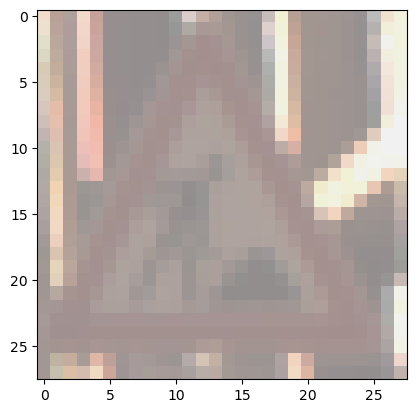

25 




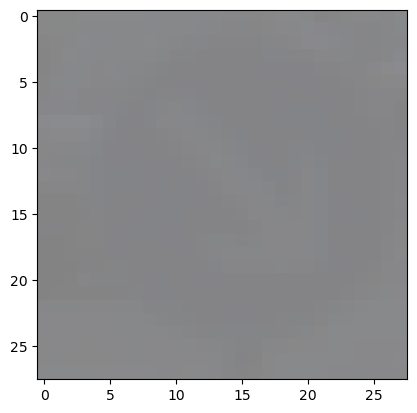

38 




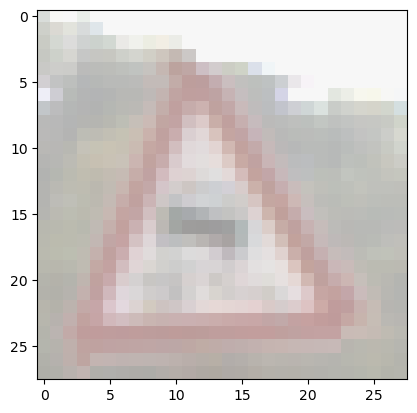

23 




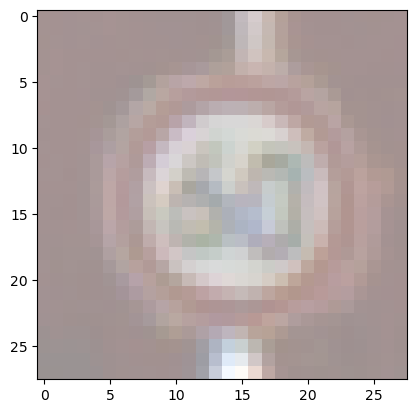

3 




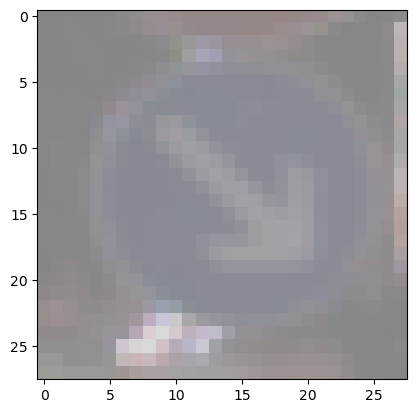

38 




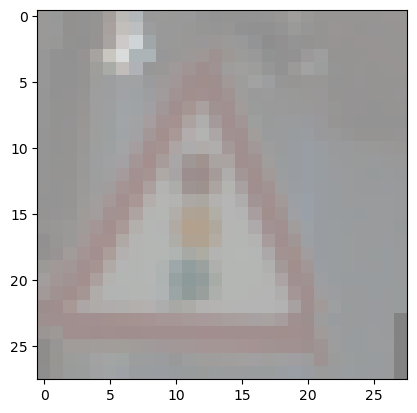

26 




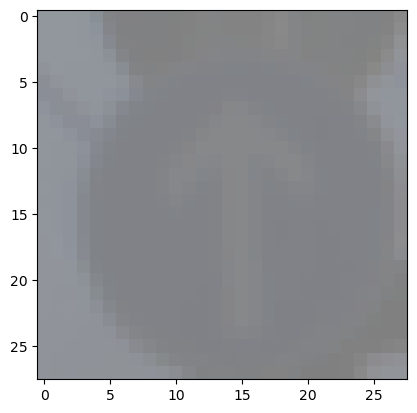

35 




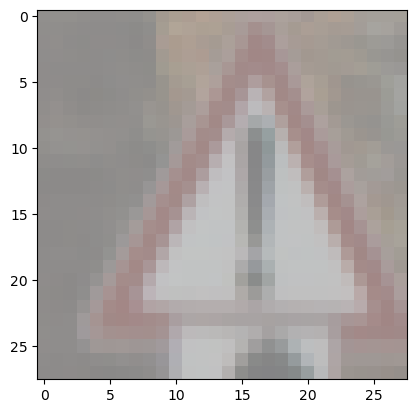

18 




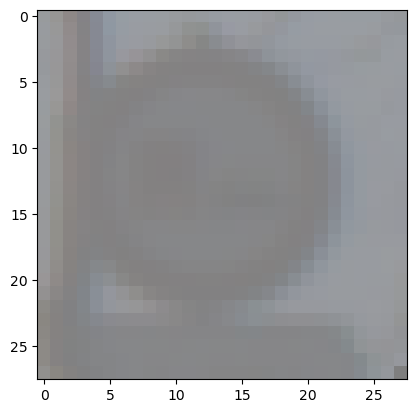

10 




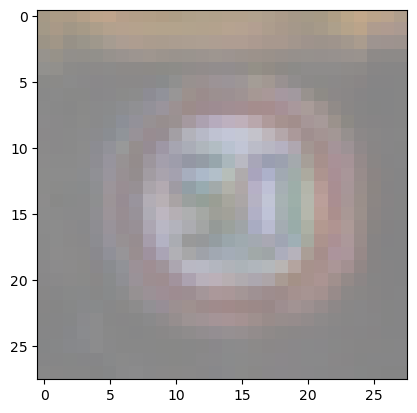

2 




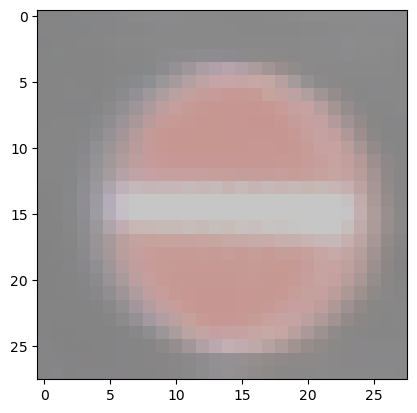

17 




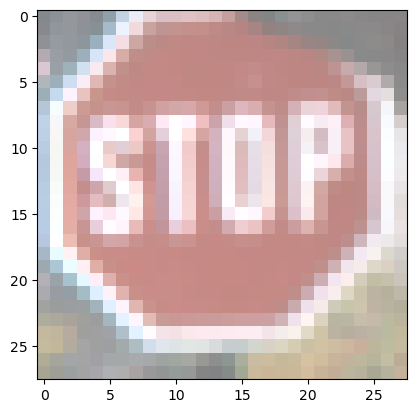

14 




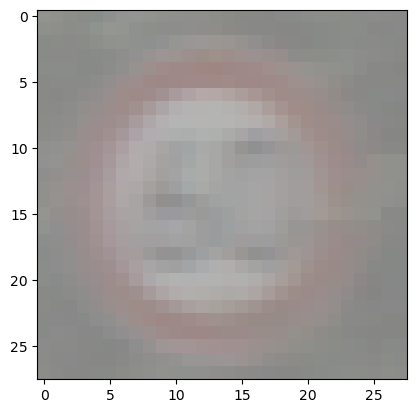

3 




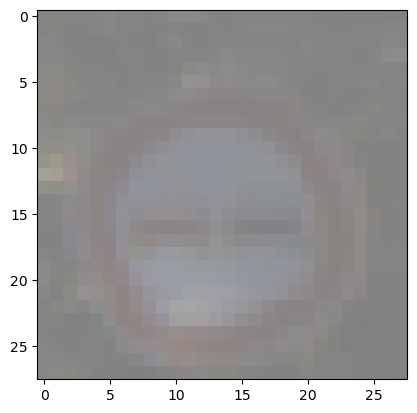

9 




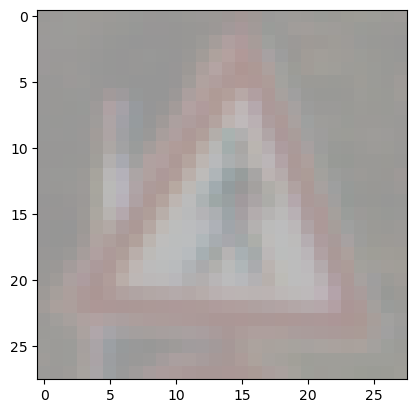

27 




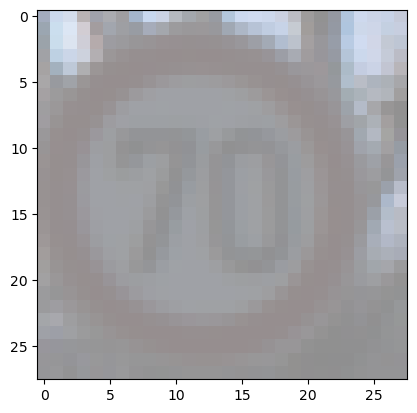

4 




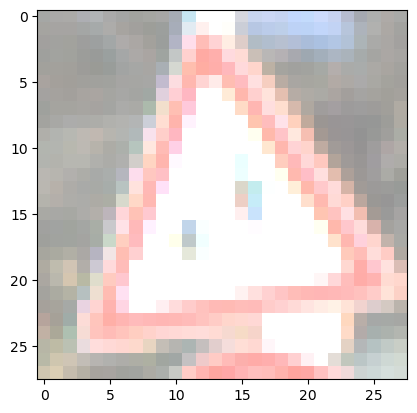

28 




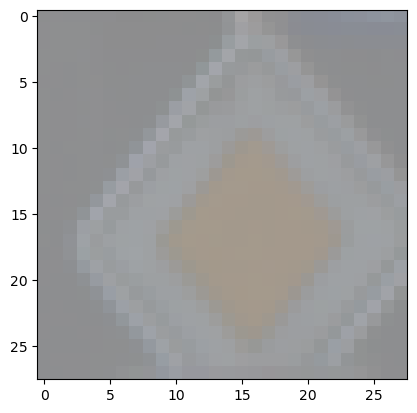

12 




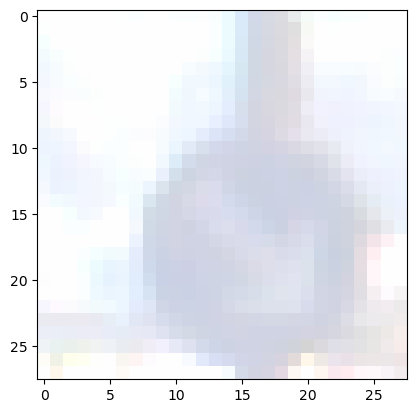

38 




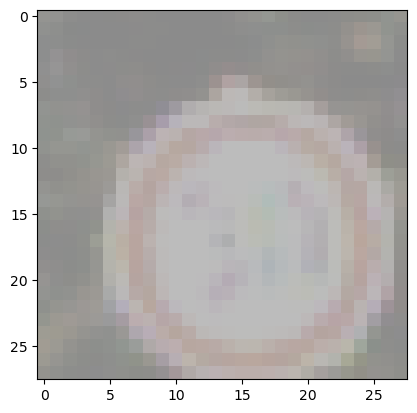

1 




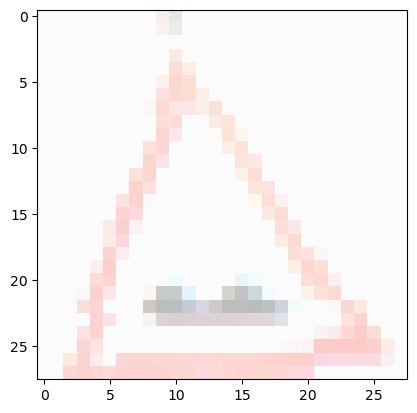

22 




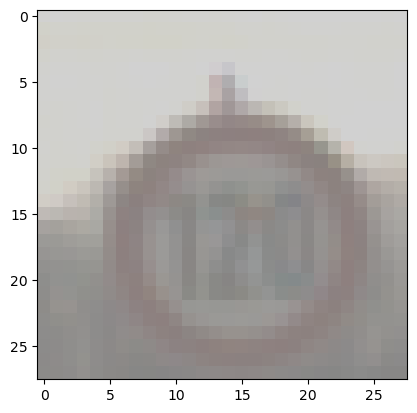

8 




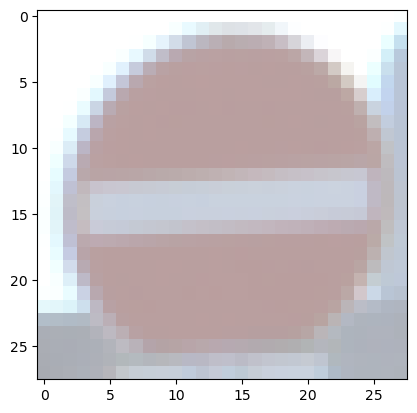

17 




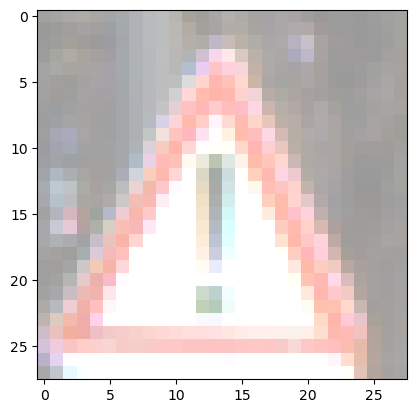

18 




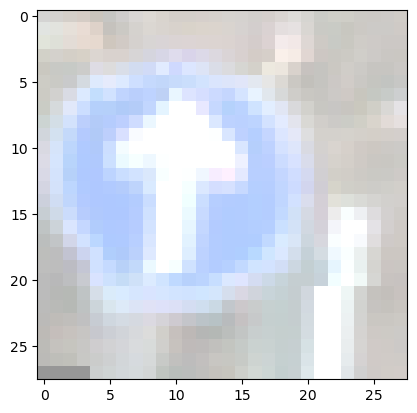

35 




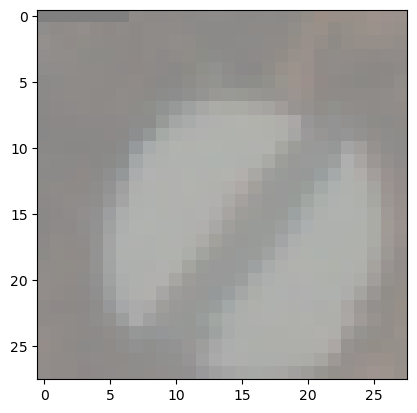

32 




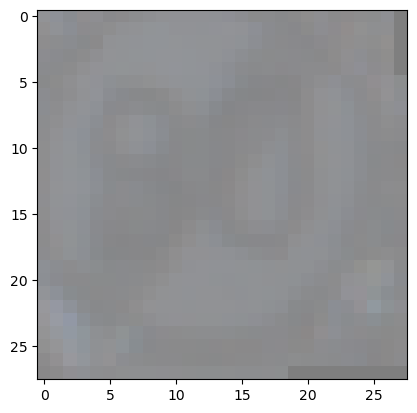

6 




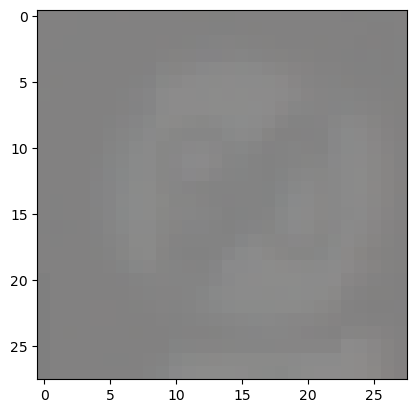

6 




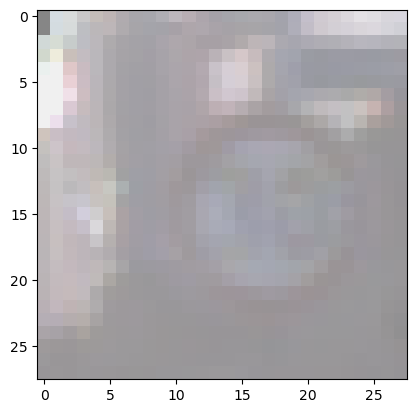

1 




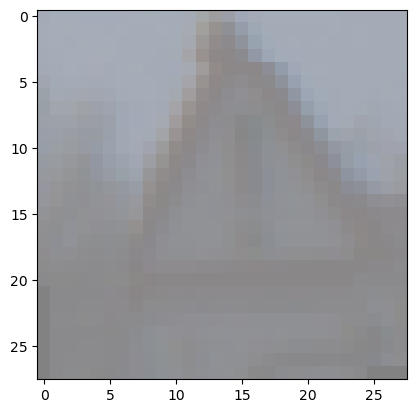

18 




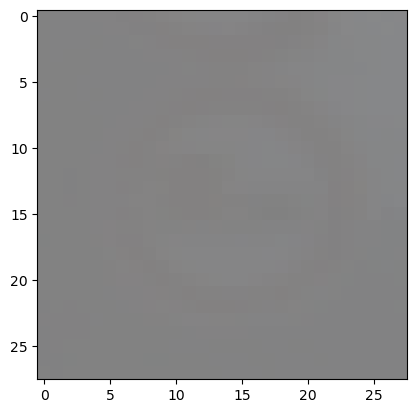

10 




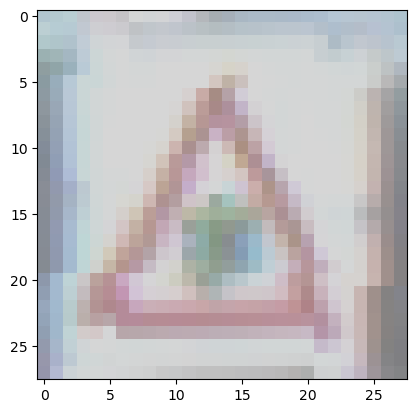

30 




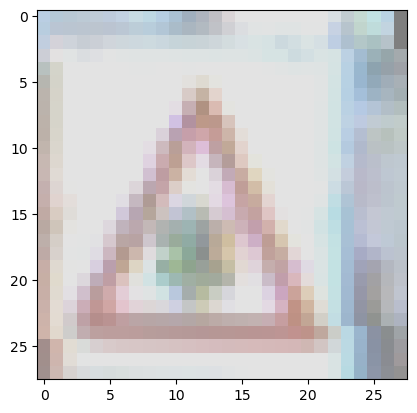

30 




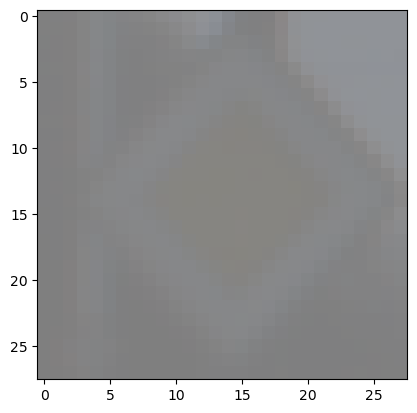

12 




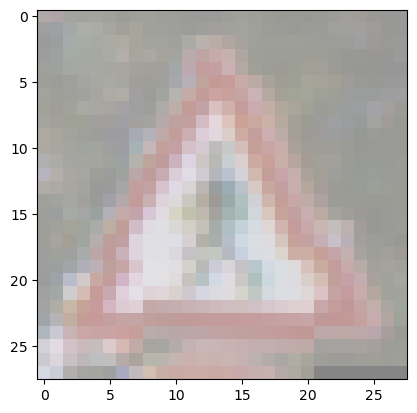

27 




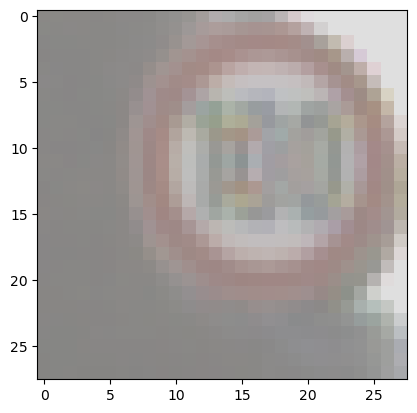

7 




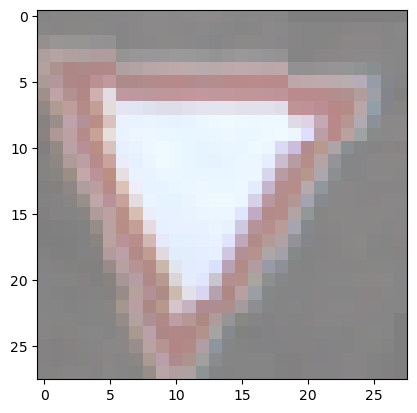

13 




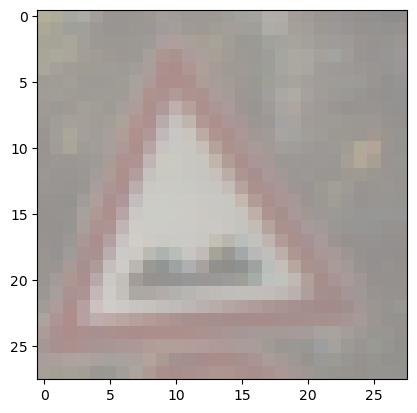

22 




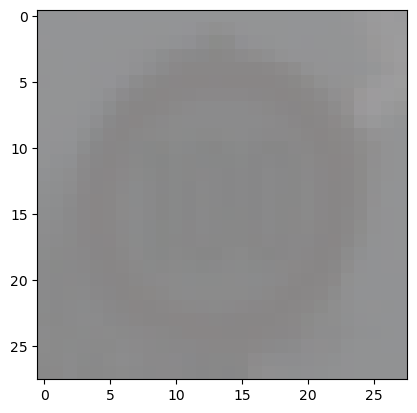

7 




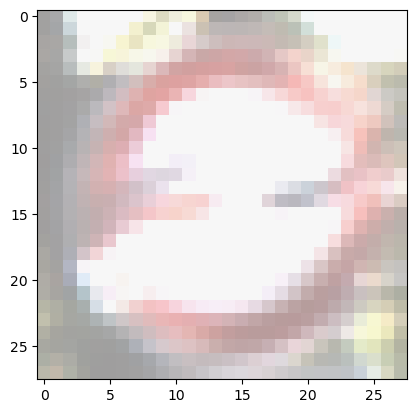

9 




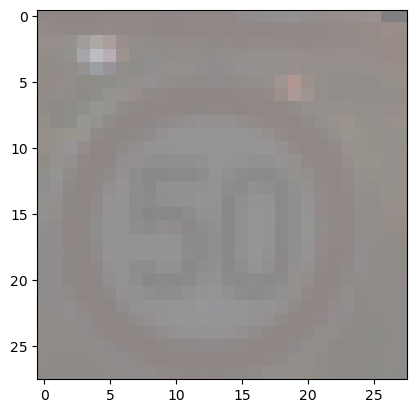

2 




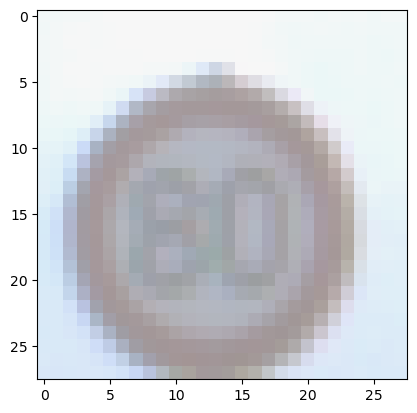

5 




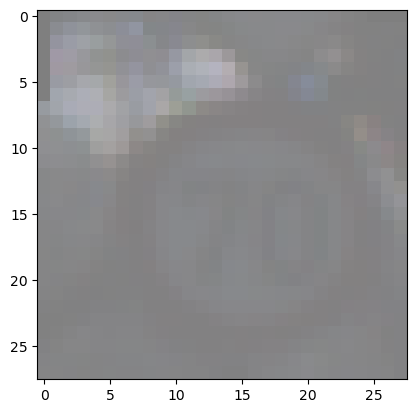

4 




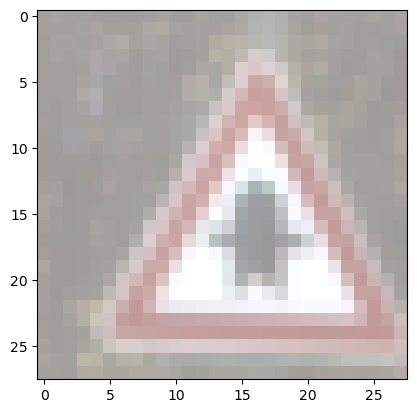

11 




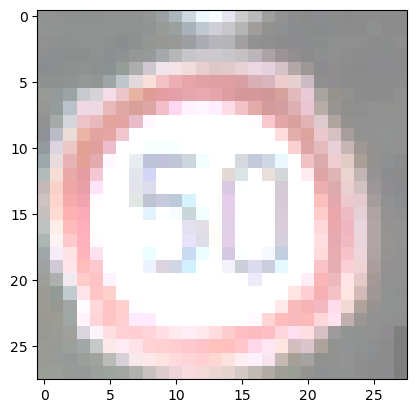

2 




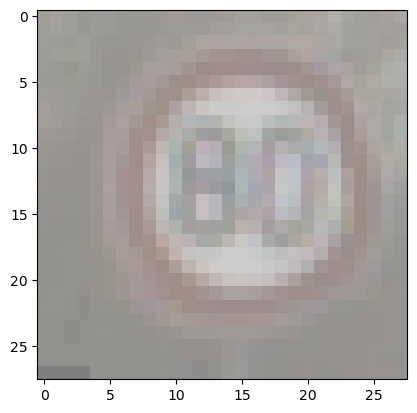

5 




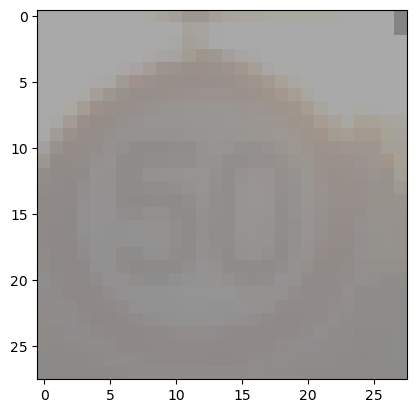

2 




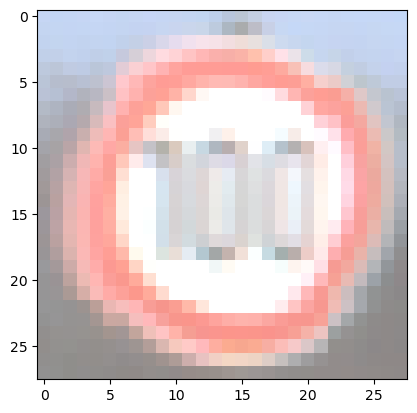

7 




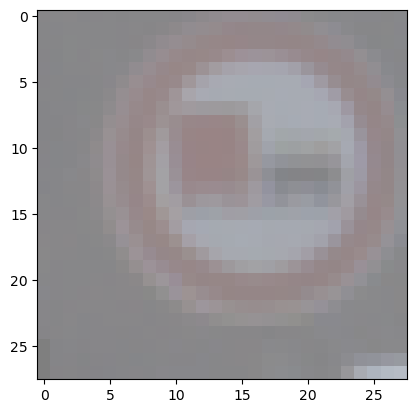

10 




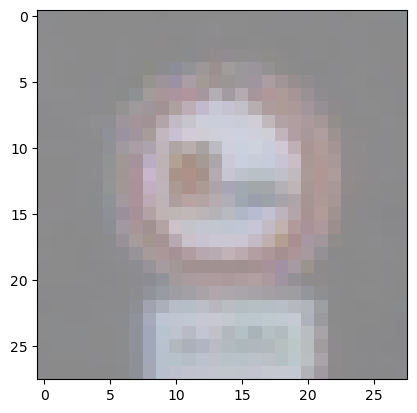

10 




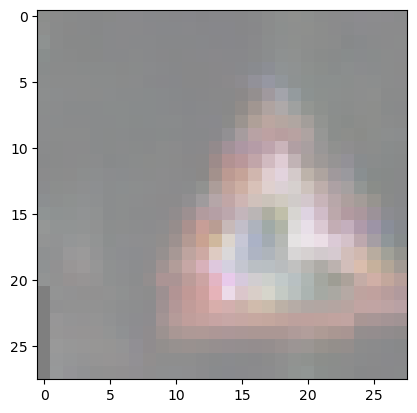

25 




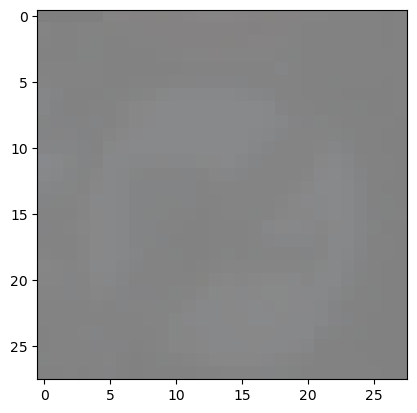

42 




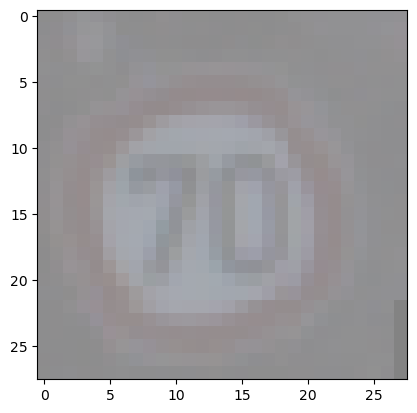

4 




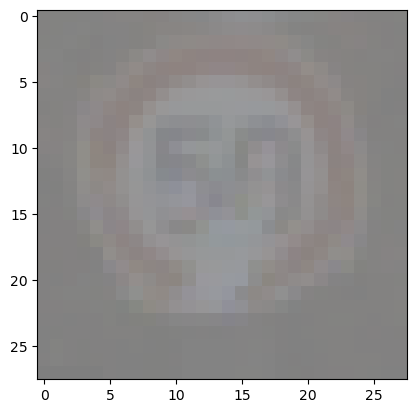

2 




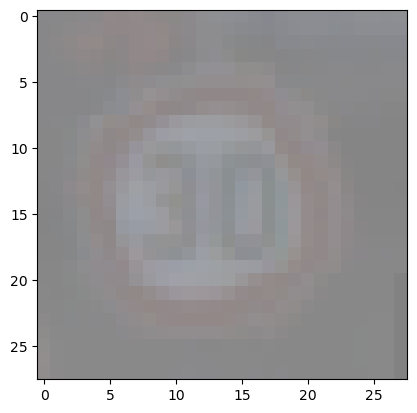

1 




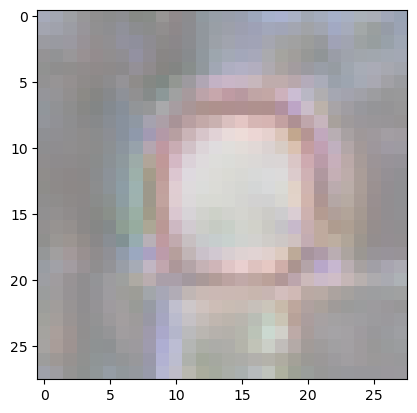

15 




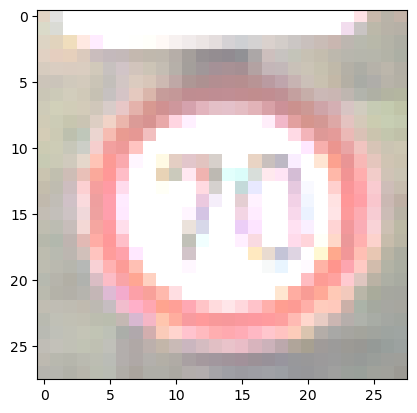

4 




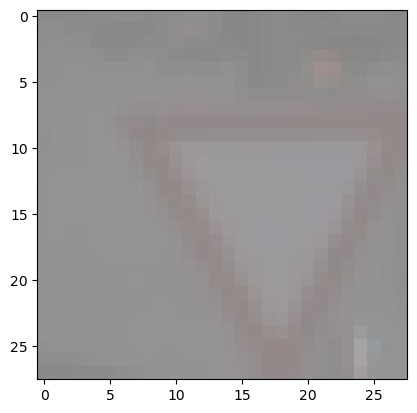

13 




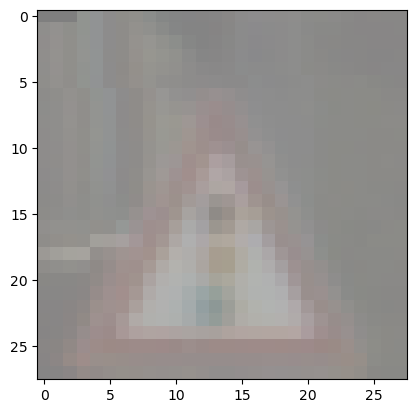

26 




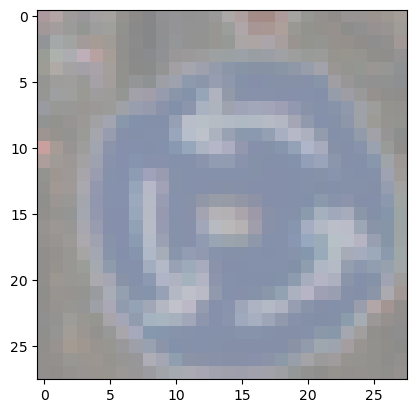

40 




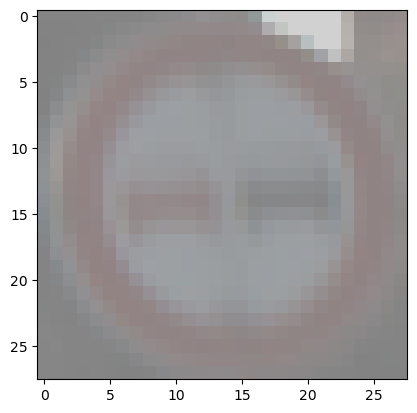

9 




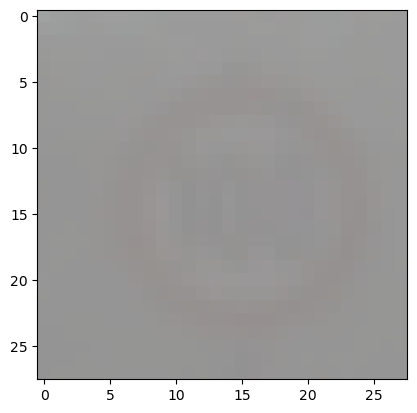

7 




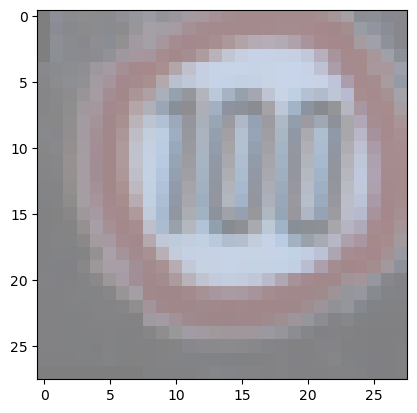

7 




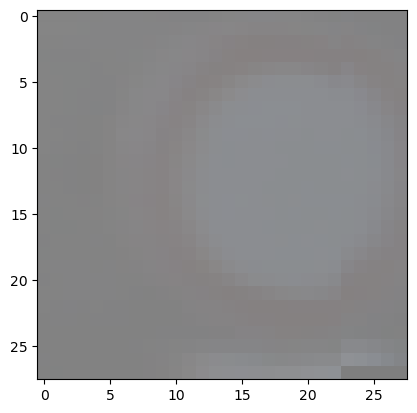

15 




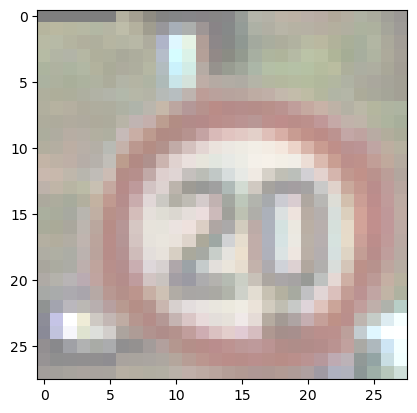

0 




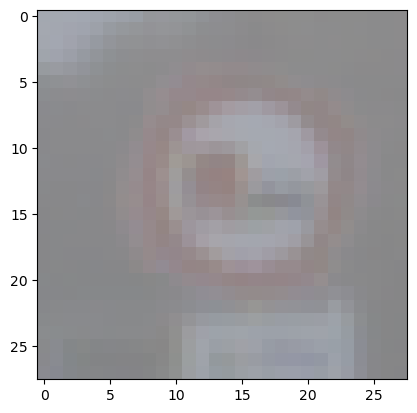

10 




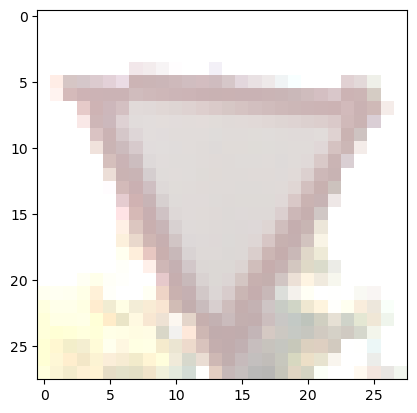

13 




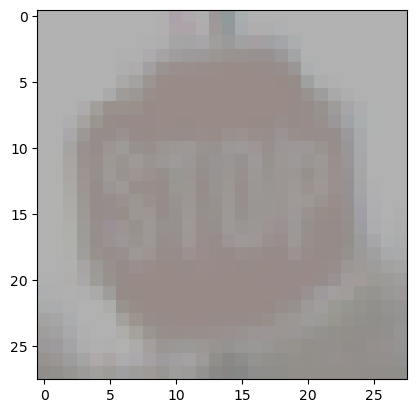

14 




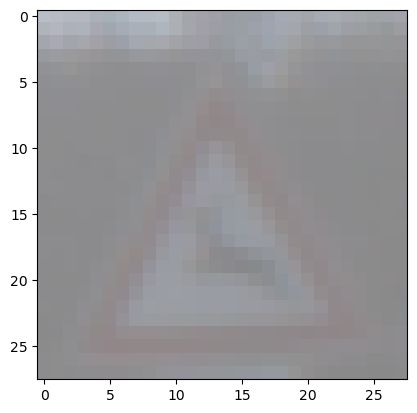

31 




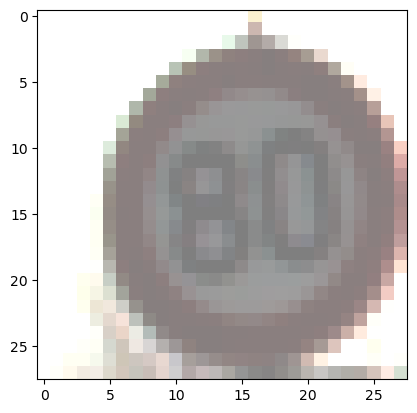

5 




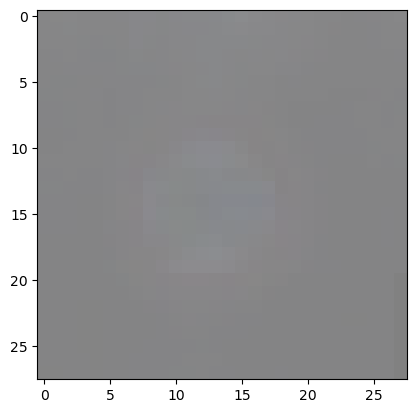

5 




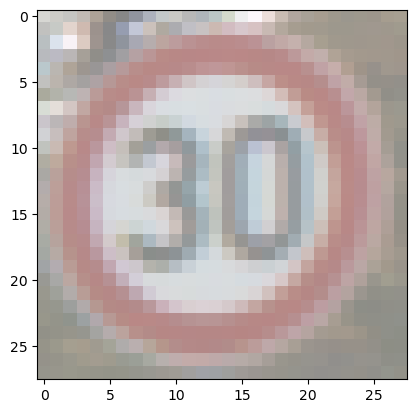

1 




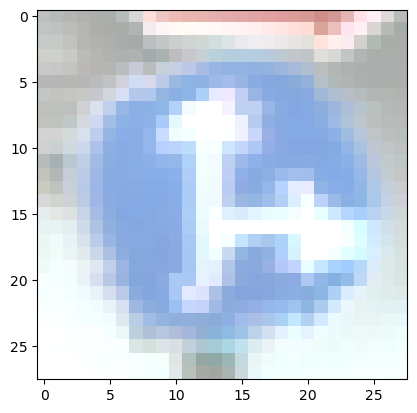

36 




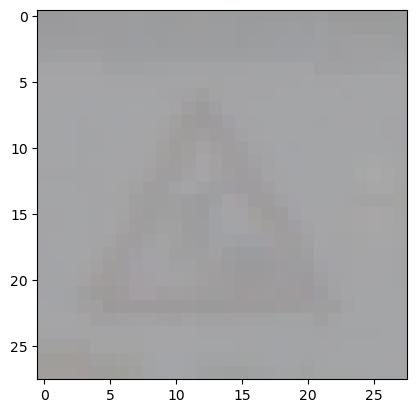

25 




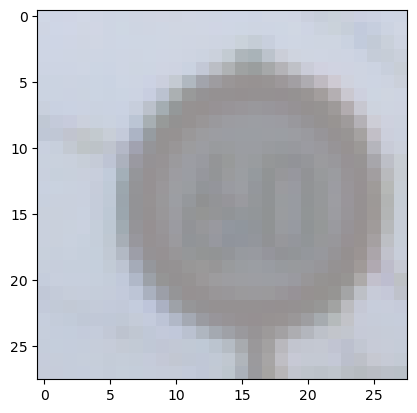

3 




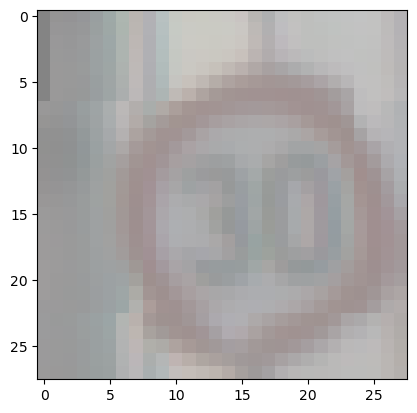

1 




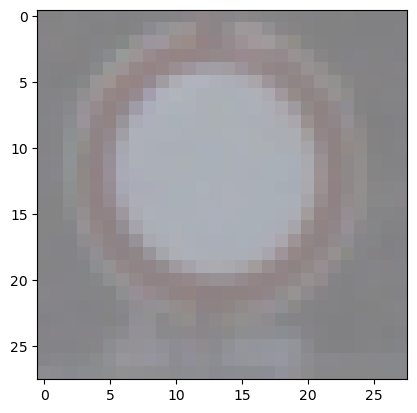

15 




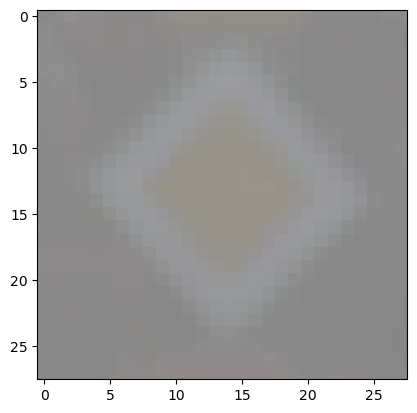

12 




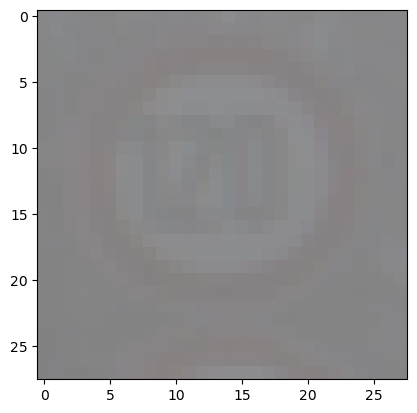

8 




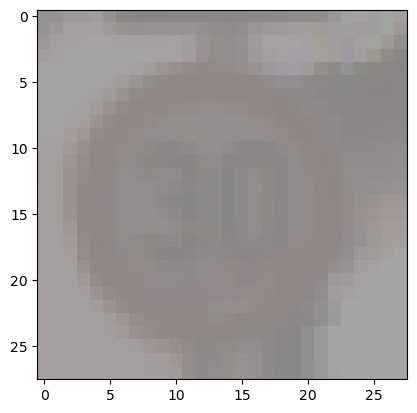

1 




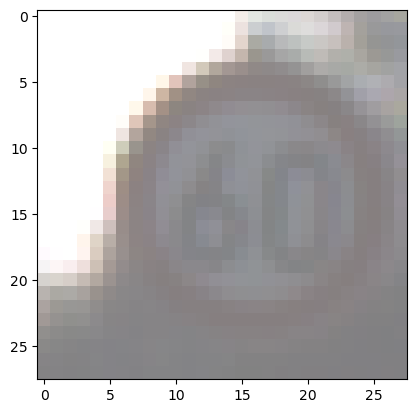

3 




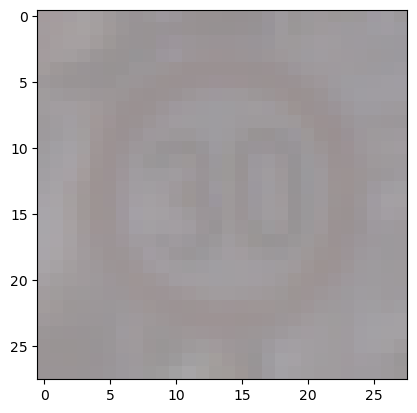

1 




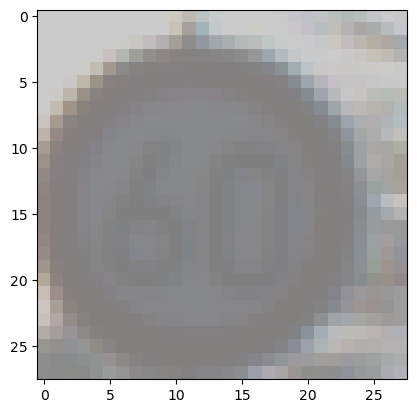

3 




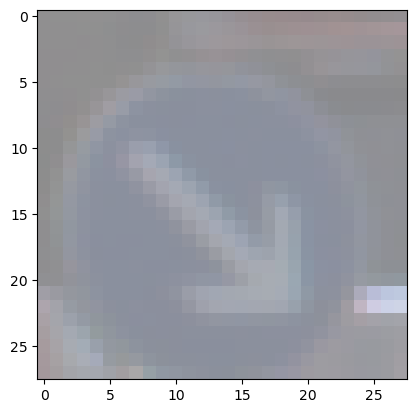

38 




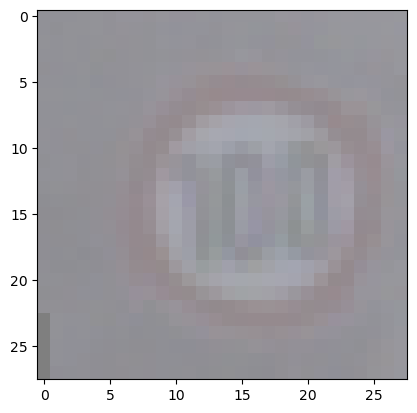

7 




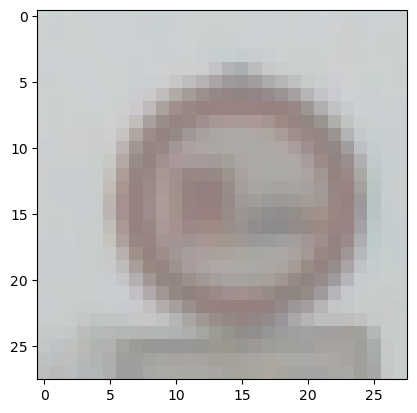

10 




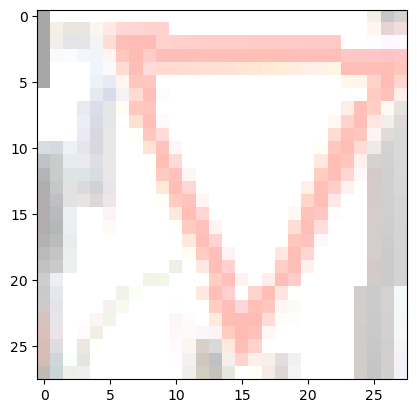

13 




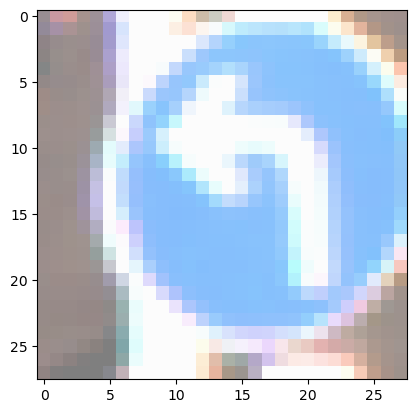

34 




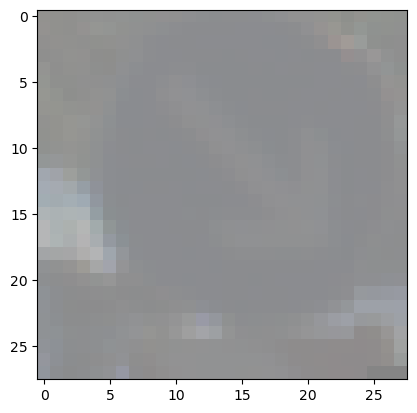

38 




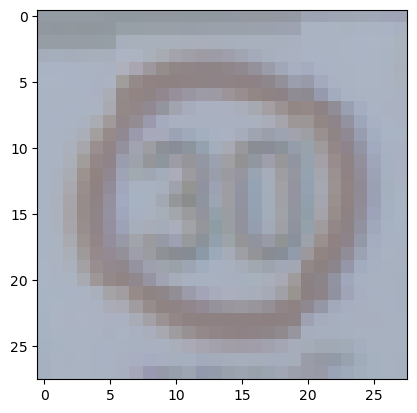

1 




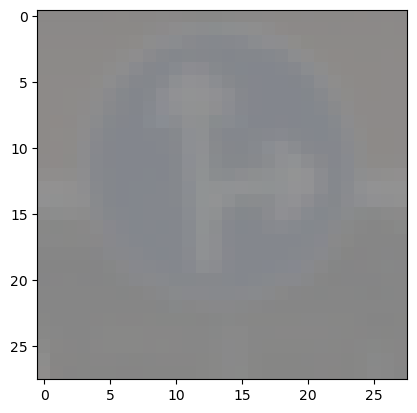

36 




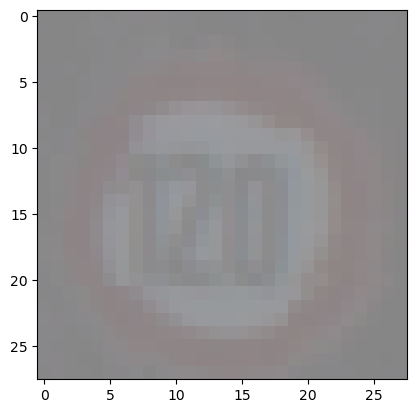

8 




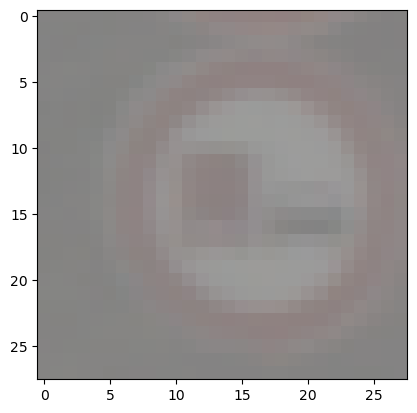

10 




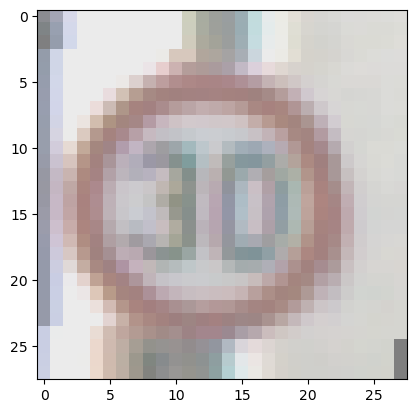

1 




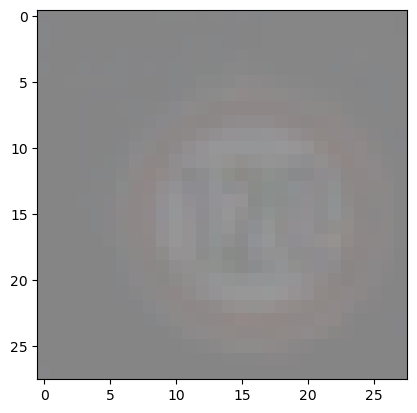

8 




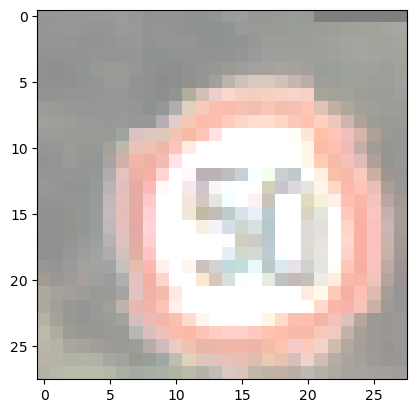

2 




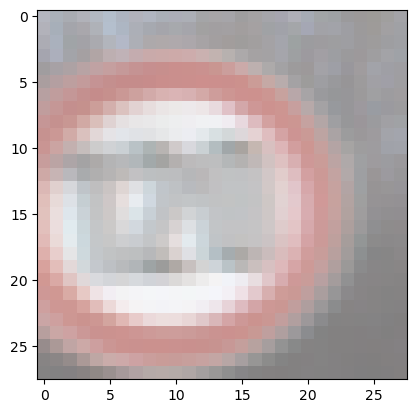

8 




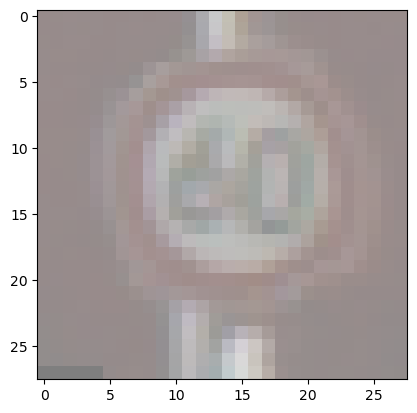

3 




In [8]:
for i in range(batch_size):
  imshow(images[i])
  print(labels[i].item(), "\n\n")


Define the neural network:

In [38]:
class Net(nn.Module):
    def __init__(self, img_size=28):
        super(Net, self).__init__()
        # Add code here ....
        
        # HC: Following added
        self.conv1 = nn.Conv2d(3, 64, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 64, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc_input_size = 1024
        self.fc2 = nn.Linear(self.fc_input_size, 43)

    def forward(self, x):
        # Add code here ....

        # HC: Following added
        x = self.pool1(F.elu(self.conv1(x)))
        x = self.pool2(F.elu(self.conv2(x)))
        x = x.view(-1, self.fc_input_size)
        x = self.fc2(x)
        return x



Instantiate the neural network and potentially move it to GPU:

In [39]:
net = Net(img_size=32)  # HC: The given image size is 32x32. img_size=32 was not specified in the original code.
if(gpu):
  net.to(device)
print(net)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc2): Linear(in_features=1024, out_features=43, bias=True)
)


Define loss and optimization algorithm:

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, eps=0.1)

These lines can be used to continue training:

In [41]:
cont = False
if cont:
  net.load_state_dict(torch.load('traffic_simple'))

Do the training:

In [42]:
no_epochs = 200
for epoch in range(no_epochs):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(generator_train, 0):
        # Get the inputs; data is a list of [inputs, labels]
        if (gpu):
          inputs, labels = data[0].to(device), data[1].to(device)
        else:
          inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        reporting_interval = 100
        running_loss += loss.item()
        if i % reporting_interval == reporting_interval-1:  # Print every reporting_interval mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / reporting_interval))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 3.610
[1,   200] loss: 3.492
[1,   300] loss: 3.426
[2,   100] loss: 3.365
[2,   200] loss: 3.246
[2,   300] loss: 3.107
[3,   100] loss: 2.968
[3,   200] loss: 2.830
[3,   300] loss: 2.687
[4,   100] loss: 2.567
[4,   200] loss: 2.452
[4,   300] loss: 2.333
[5,   100] loss: 2.227
[5,   200] loss: 2.134
[5,   300] loss: 2.031
[6,   100] loss: 1.938
[6,   200] loss: 1.883
[6,   300] loss: 1.816
[7,   100] loss: 1.743
[7,   200] loss: 1.673
[7,   300] loss: 1.591
[8,   100] loss: 1.557
[8,   200] loss: 1.501
[8,   300] loss: 1.460
[9,   100] loss: 1.416
[9,   200] loss: 1.362
[9,   300] loss: 1.326
[10,   100] loss: 1.274
[10,   200] loss: 1.260
[10,   300] loss: 1.228
[11,   100] loss: 1.182
[11,   200] loss: 1.146
[11,   300] loss: 1.130
[12,   100] loss: 1.092
[12,   200] loss: 1.082
[12,   300] loss: 1.033
[13,   100] loss: 1.058
[13,   200] loss: 1.006
[13,   300] loss: 0.969
[14,   100] loss: 0.961
[14,   200] loss: 0.948
[14,   300] loss: 0.924
[15,   100] loss: 0

Evaluate on test set:

In [43]:
dataset_test = GTSRBTrafficSigns(train=False)
generator_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=4)
print("Number of test patterns:", dataset_test.__len__())

Using existing ./GTSRB/test
Number of test patterns: 12630


In [44]:
correct = 0
total = 0
with torch.no_grad():
    for data in generator_test:
        if (gpu):
          images, labels = data[0].to(device), data[1].to(device)
        else:
          images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on test images: 94.35 %


Save network:

In [45]:
torch.save(net.state_dict(), 'traffic_simple')